In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.colors as mcolors

import matplotlib.cm as cm
import seaborn as sns

In [2]:
def boxplot_general(metrica):
    plt.figure(figsize=(4, 4))
    sns.boxplot(y=df_metricas_overall[metrica], color='skyblue', showmeans=True, meanprops={"marker":"o",
                        "markerfacecolor":"red", "markeredgecolor":"black", "markersize":5})
    sns.stripplot(y=df_metricas_overall[metrica], color='black', alpha=0.5, jitter=True)


    plt.title(f'Distribución de {metrica}.')
    plt.ylabel(f'{metrica}')
    plt.show()

    
def boxplot_source(metrica):
    plt.figure(figsize=(10, 4))

    # Boxplot con filtro CHIRPS
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df_metricas_overall[df_metricas_overall['source'] == 'chirps'][metrica], color='lightgreen', showmeans=True, meanprops={"marker":"o",
                        "markerfacecolor":"red", "markeredgecolor":"black", "markersize":8})
    sns.stripplot(y=df_metricas_overall[df_metricas_overall['source'] == 'chirps'][metrica], color='black', alpha=0.5, jitter=True)
    plt.title(f'Distribución de {metrica} (CHIRPS)')
    plt.ylabel("")

    # Boxplot con filtro AGERA
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_metricas_overall[df_metricas_overall['source'] == 'agera5'][metrica], color='salmon', showmeans=True, meanprops={"marker":"o",
                        "markerfacecolor":"red", "markeredgecolor":"black", "markersize":8})
    sns.stripplot(y=df_metricas_overall[df_metricas_overall['source'] == 'agera5'][metrica], color='black', alpha=0.5, jitter=True)
    plt.title(f'Distribución de {metrica} (AGERA)')
    plt.ylabel("")


    plt.tight_layout()
    plt.show()

In [3]:
df_metricas= pd.read_parquet('data/overall_metrics.parquet')
georefe= pd.read_parquet('data/prec_monthly_obs_sat.parquet')[['latitud','longitud','station']].drop_duplicates(keep='first').reset_index(drop=True)

In [4]:
df_metricas_overall=georefe.merge(df_metricas, on='station', how='inner')
df_metricas_overall.head(3)

,latitud,longitud,station,clasificacion,departamento,municipio,r2,r2_ajustado,rmse,mae,std,kge,spearman,bias,mape,maape,source
0,2.69814,-75.29815,FEDEARROZ_CAMPOALEGRE_ALTAGRACIA,A,HUILA,CAMPOALEGRE,0.001535,-0.089235,648.273641,476.130769,629.298960,0.138778,0.390110,-155.696924,45.456140,0.387893,agera5
1,2.69814,-75.29815,FEDEARROZ_CAMPOALEGRE_ALTAGRACIA,A,HUILA,CAMPOALEGRE,0.065542,-0.019409,627.150655,455.459175,607.499815,0.362725,0.582418,155.762379,45.807979,0.387382,chirps
2,2.88457,-75.44166,FEDEARROZ_PALERMO_ASOJUNCAL,B,HUILA,PALERMO,0.393468,0.332814,407.652418,368.888333,403.588203,0.502848,0.615385,57.420000,50.824213,0.438237,agera5


# METRICAS STANDAR

In [5]:
cd

/home/jupyter


## MAPE

In [6]:
# Definir los límites para MAPE
limites_mape = {
    "Excelente": (0, 20),
    "Bueno": (20, 35),
    "Regular": (35, 50),
    "Malo": (50, float("inf"))
}

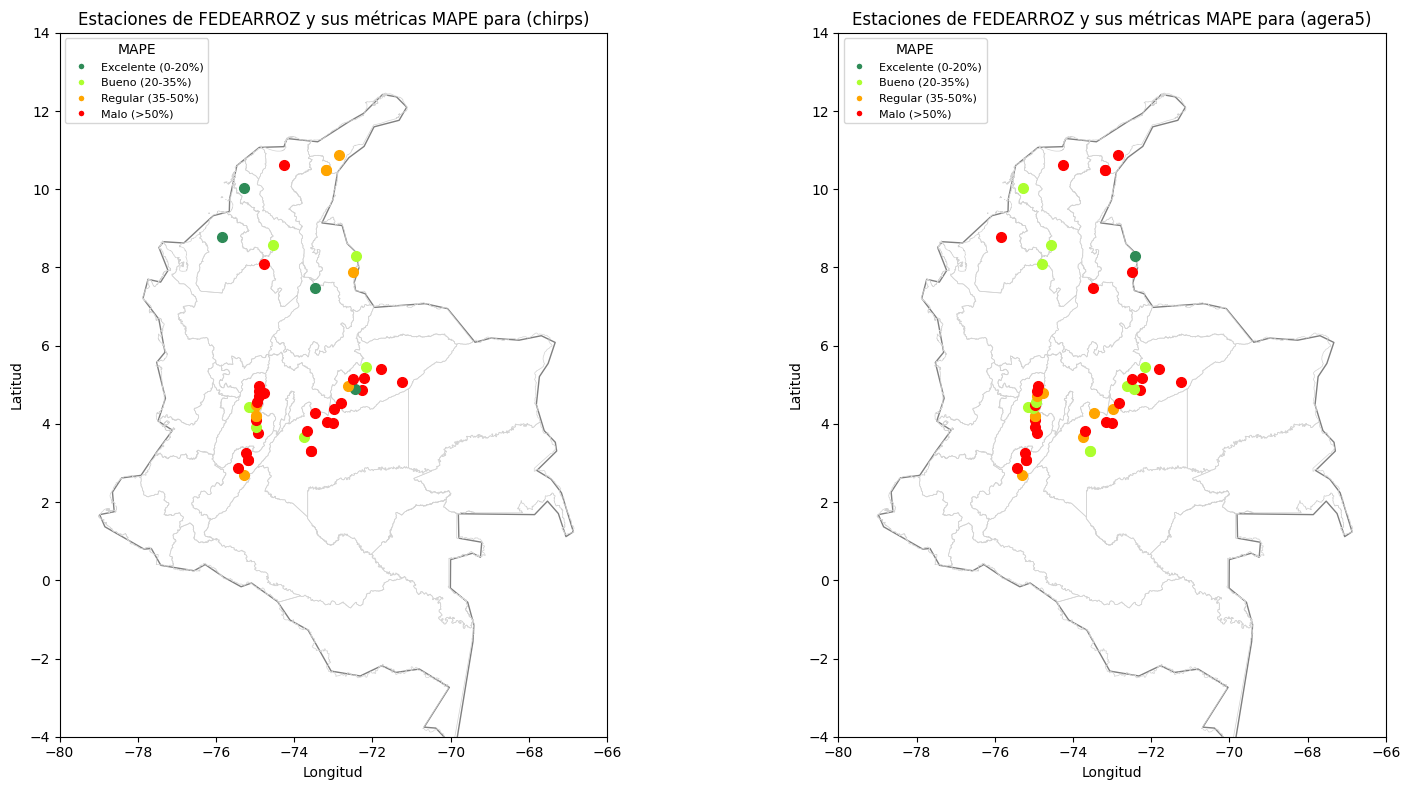

In [7]:

# Cargar el shapefile de Colombia y departamentos
shapefile_path = 'csicap_fedearroz_evaluacion/maps/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)
colombia = world[world['SOV_A3'] == 'COL']

# departamentos de Colombia
departments_shapefile = 'csicap_fedearroz_evaluacion/maps/MGN_ADM_DPTO_POLITICO.shp'
departments = gpd.read_file(departments_shapefile)


def plot_mape(df, source, ax):
    df_source = df[df['source'] == source]
    
    #Colombia en blanco
    colombia.plot(ax=ax, edgecolor='gray', facecolor='white')
    #  departamentos en gris claro
    departments.plot(ax=ax, edgecolor='lightgray', facecolor='none', linewidth=0.5)

    # colores según el valor de MAPE
    def get_color(mape):
        if limites_mape["Excelente"][0] <= mape < limites_mape["Excelente"][1]:
            return '#2E8B57'  # Verde oscuro
        elif limites_mape["Bueno"][0] <= mape < limites_mape["Bueno"][1]:
            return '#ADFF2F'  # Amarillo verdoso
        elif limites_mape["Regular"][0] <= mape < limites_mape["Regular"][1]:
            return 'orange'
        else:
            return 'red'

    #pintar los ptos
    for _, row in df_source.iterrows():
        ax.plot(row['longitud'], row['latitud'], marker='o', markersize=7, color=get_color(row['mape']), label=row['station'])

   
    ax.set_xlim([-80, -66])
    ax.set_ylim([-4, 14])
    ax.set_aspect('equal')
    
    # leyenda mape
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Excelente (0-20%)', markerfacecolor='#2E8B57', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Bueno (20-35%)', markerfacecolor='#ADFF2F', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Regular (35-50%)', markerfacecolor='orange', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Malo (>50%)', markerfacecolor='red', markersize=5)
    ]
    
    ax.legend(handles=legend_elements, title="MAPE", loc='upper left', fontsize=8)

    # Título y etiquetas
    ax.set_title(f'Estaciones de FEDEARROZ y sus métricas MAPE para ({source})', fontsize=12)
    ax.set_xlabel('Longitud', fontsize=10)
    ax.set_ylabel('Latitud', fontsize=10)

# Crear la figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plot_mape(df_metricas_overall, 'chirps', ax=ax1)
plot_mape(df_metricas_overall, 'agera5', ax=ax2)


plt.tight_layout()
plt.show()


## KGE

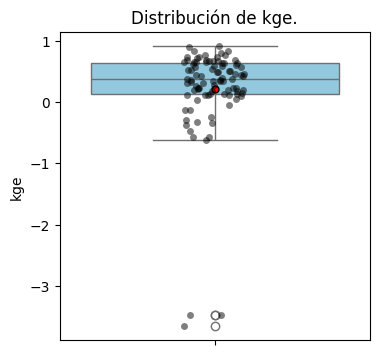

In [8]:
boxplot_general('kge')

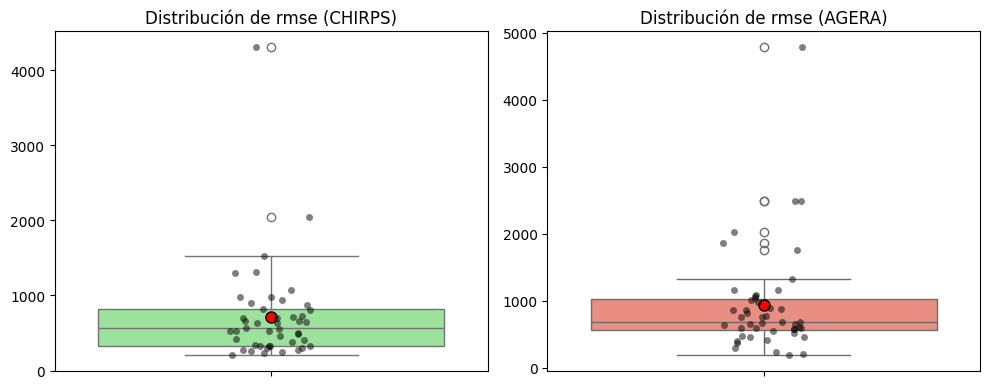

In [9]:
boxplot_source('rmse')

In [10]:
limites_kge = {
    "Excelente": (0.8, 1.0),
    "Bueno": (0.6, 0.8),
    "Regular": (0.3, 0.6),
    "Deficiente": (-float("inf"),0.3)
}

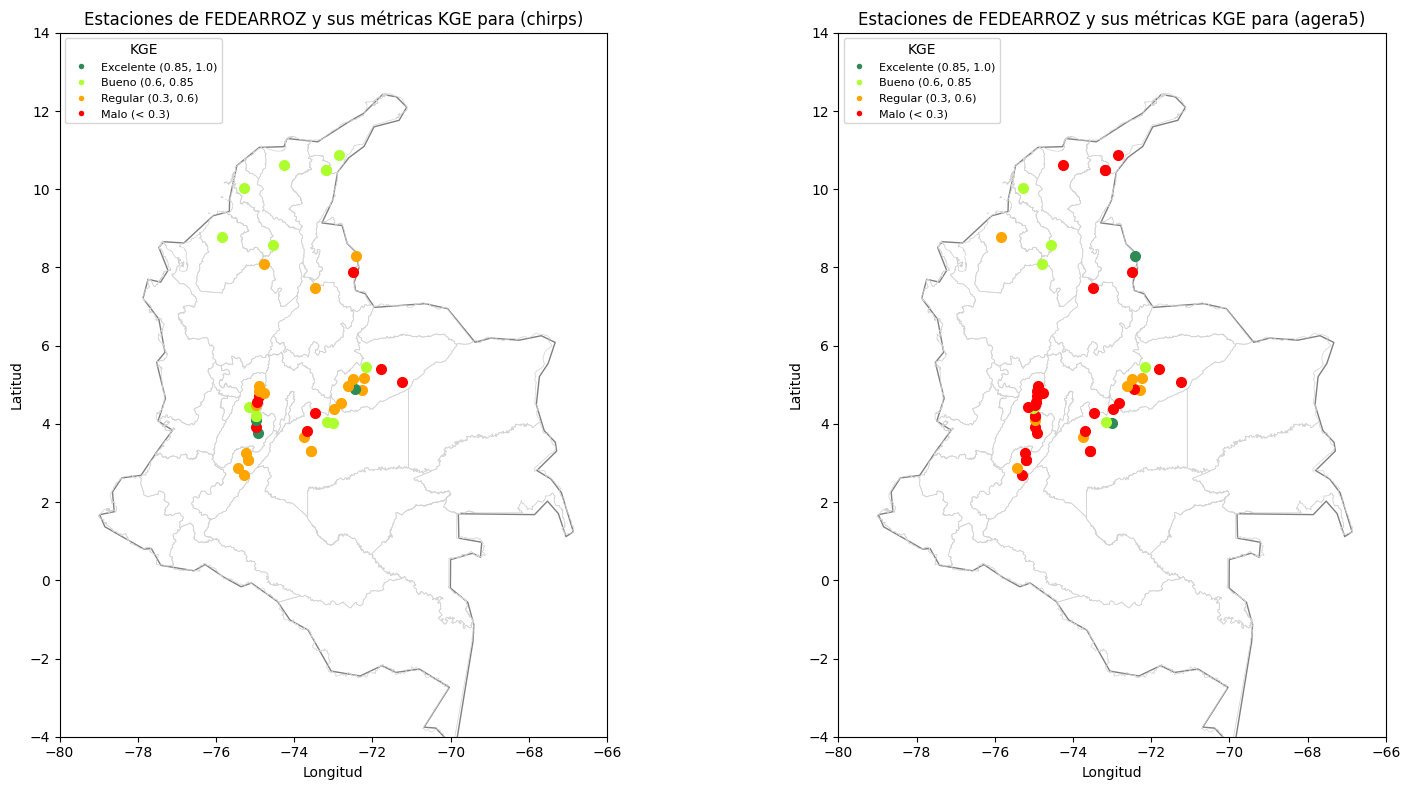

In [11]:
def plot_map_kge(df, source, ax):
    df_source = df[df['source'] == source]
    
    #Colombia en blanco
    colombia.plot(ax=ax, edgecolor='gray', facecolor='white')
    #  departamentos en gris claro
    departments.plot(ax=ax, edgecolor='lightgray', facecolor='none', linewidth=0.5)

    # colores según el valor de MAPE
    def get_color(kge):
        if limites_kge["Excelente"][0] <= kge <= limites_kge["Excelente"][1]:
            return '#2E8B57'  # Verde oscuro
        elif limites_kge["Bueno"][0] <= kge < limites_kge["Bueno"][1]:
            return '#ADFF2F'  # Amarillo verdoso
        elif limites_kge["Regular"][0] <= kge < limites_kge["Regular"][1]:
            return 'orange'
        else:
            return 'red'

    #pintar los ptos
    for _, row in df_source.iterrows():
        ax.plot(row['longitud'], row['latitud'], marker='o', markersize=7, color=get_color(row['kge']), label=row['station'])

   
    ax.set_xlim([-80, -66])
    ax.set_ylim([-4, 14])
    ax.set_aspect('equal')
    
    # leyenda mape
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Excelente (0.85, 1.0)', markerfacecolor='#2E8B57', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Bueno (0.6, 0.85', markerfacecolor='#ADFF2F', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Regular (0.3, 0.6)', markerfacecolor='orange', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Malo (< 0.3)', markerfacecolor='red', markersize=5)
    ]
    
    ax.legend(handles=legend_elements, title="KGE", loc='upper left', fontsize=8)

    # Título y etiquetas
    ax.set_title(f'Estaciones de FEDEARROZ y sus métricas KGE para ({source})', fontsize=12)
    ax.set_xlabel('Longitud', fontsize=10)
    ax.set_ylabel('Latitud', fontsize=10)

# Crear la figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plot_map_kge(df_metricas_overall, 'chirps', ax=ax1)
plot_map_kge(df_metricas_overall, 'agera5', ax=ax2)


plt.tight_layout()
plt.show()

## SPEARMAN

In [12]:
df_metricas_overall.spearman.max()

1.0

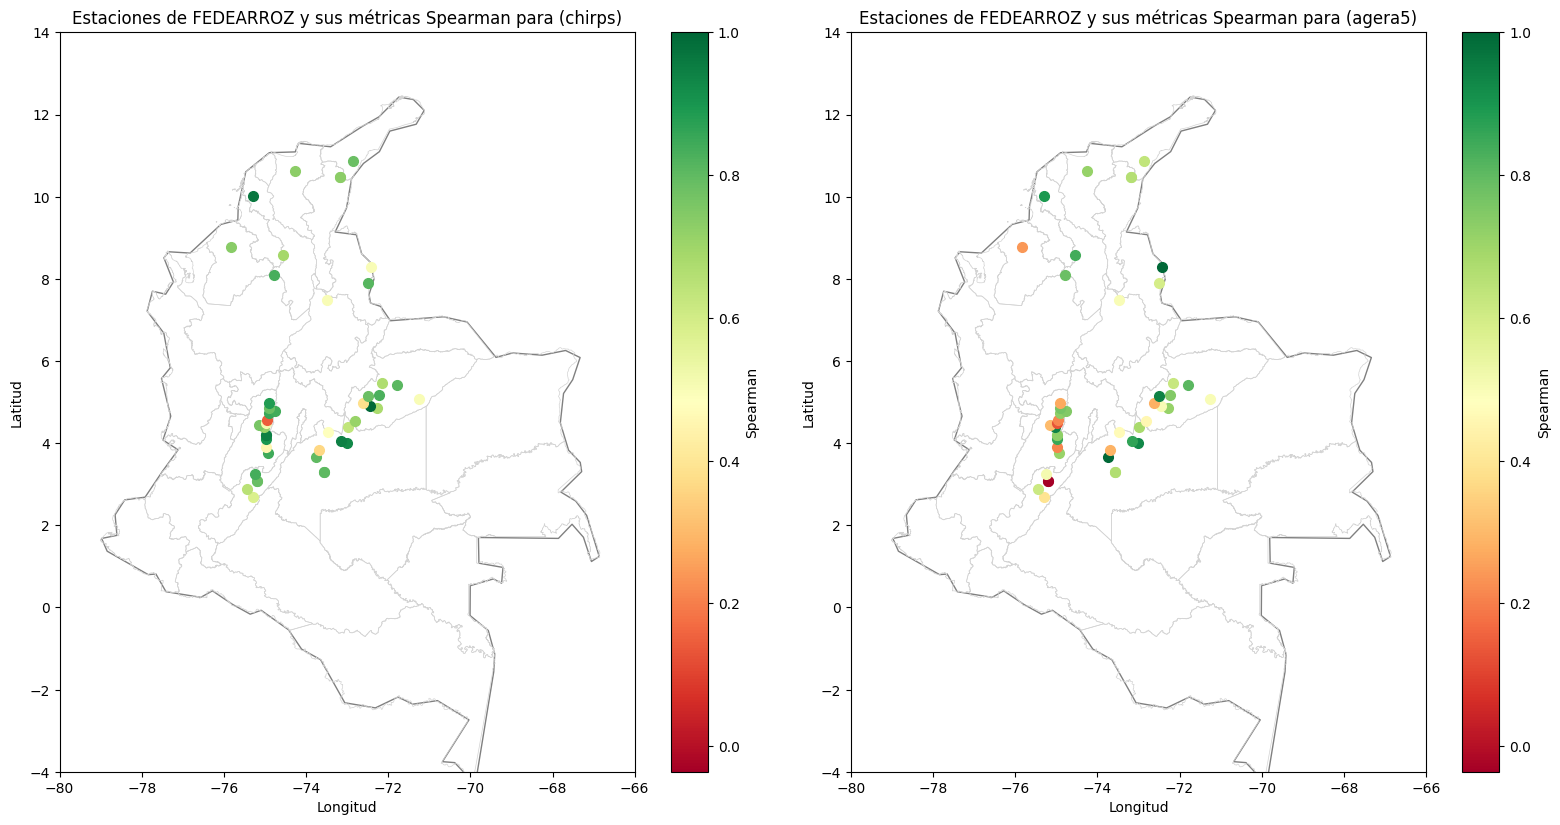

In [15]:


def plot_spearman(df, source, ax):
    df_source = df[df['source'] == source]
    
    colombia.plot(ax=ax, edgecolor='gray', facecolor='white')
    departments.plot(ax=ax, edgecolor='lightgray', facecolor='none', linewidth=0.5)


    cmap = cm.RdYlGn  # Colormap de rojo a verde
    norm = mcolors.Normalize(vmin=df_metricas_overall.spearman.min(), vmax=df_metricas_overall.spearman.max())  #los limites no van de -1 a 1

    
    for _, row in df_source.iterrows():
        spearman_value = row['spearman']
        color = cmap(norm(spearman_value))
        ax.plot(row['longitud'], row['latitud'], marker='o', markersize=7, color=color, label=row['station'])


    ax.set_xlim([-80, -66])
    ax.set_ylim([-4, 14])
    ax.set_aspect('equal')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Spearman')


    ax.set_title(f'Estaciones de FEDEARROZ y sus métricas Spearman para ({source})', fontsize=12)
    ax.set_xlabel('Longitud', fontsize=10)
    ax.set_ylabel('Latitud', fontsize=10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plot_spearman(df_metricas_overall, 'chirps', ax=ax1)
plot_spearman(df_metricas_overall, 'agera5', ax=ax2)

plt.tight_layout()
plt.show()


# Métricas no estandarizadas

## RMSE

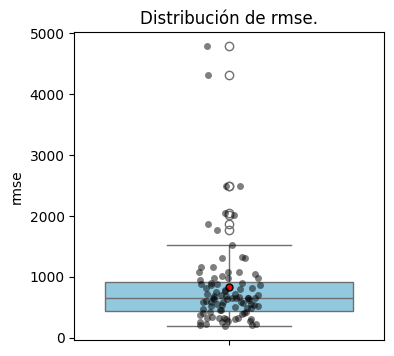

In [16]:
boxplot_general('rmse')

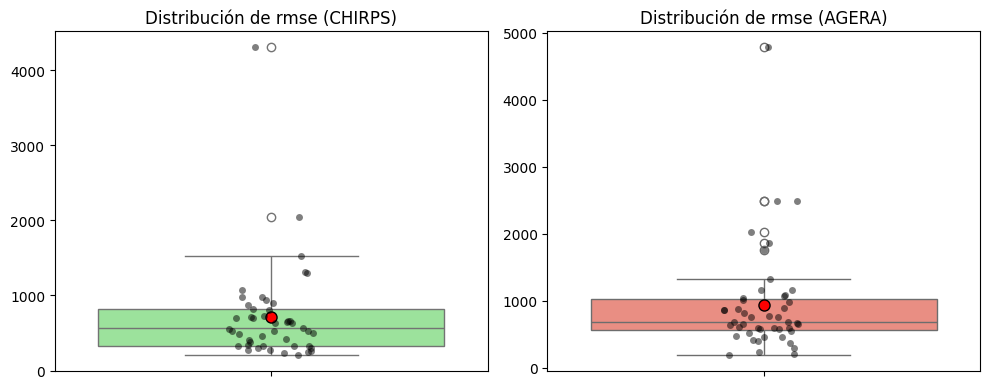

In [17]:
boxplot_source('rmse')

In [18]:

# Calcular las estadísticas
q1 = df_metricas_overall[df_metricas_overall['source'] == 'chirps']['rmse'].quantile(0.25)
q2 = df_metricas_overall[df_metricas_overall['source'] == 'chirps']['rmse'].quantile(0.5)  # Mediana
q3 = df_metricas_overall[df_metricas_overall['source'] == 'chirps']['rmse'].quantile(0.75)
mean = df_metricas_overall[df_metricas_overall['source'] == 'chirps']['rmse'].mean()

# Crear un diccionario con los resultados
summary_chirps = {
    "Q1": q1,
    "Q2 (Mediana)": q2,
    "Q3": q3,
    "Promedio": mean
}

# Mostrar los resultados
summary_chirps

{'Q1': 328.90541008612166,
 'Q2 (Mediana)': 560.7441031196923,
 'Q3': 814.1828687230051,
 'Promedio': 717.0518563470501}

In [19]:

# Calcular las estadísticas
q1 = df_metricas_overall[df_metricas_overall['source'] == 'agera5']['rmse'].quantile(0.25)
q2 = df_metricas_overall[df_metricas_overall['source'] == 'agera5']['rmse'].quantile(0.5)  # Mediana
q3 = df_metricas_overall[df_metricas_overall['source'] == 'agera5']['rmse'].quantile(0.75)
mean = df_metricas_overall[df_metricas_overall['source'] == 'agera5']['rmse'].mean()

# Crear un diccionario con los resultados
summary_agera = {
    "Q1": q1,
    "Q2 (Mediana)": q2,
    "Q3": q3,
    "Promedio": mean
}

# Mostrar los resultados
summary_agera

{'Q1': 562.0877913575333,
 'Q2 (Mediana)': 682.1200877381633,
 'Q3': 1031.8056230553366,
 'Promedio': 934.2167161059979}

In [20]:
# Definir los límites para MAPE
limites_rmse = {
    "Bajo": (0, 328),
    "Moderado": (328, 530),
    "Alto": (530, 732),
    "Excedido": (732, float("inf"))
}

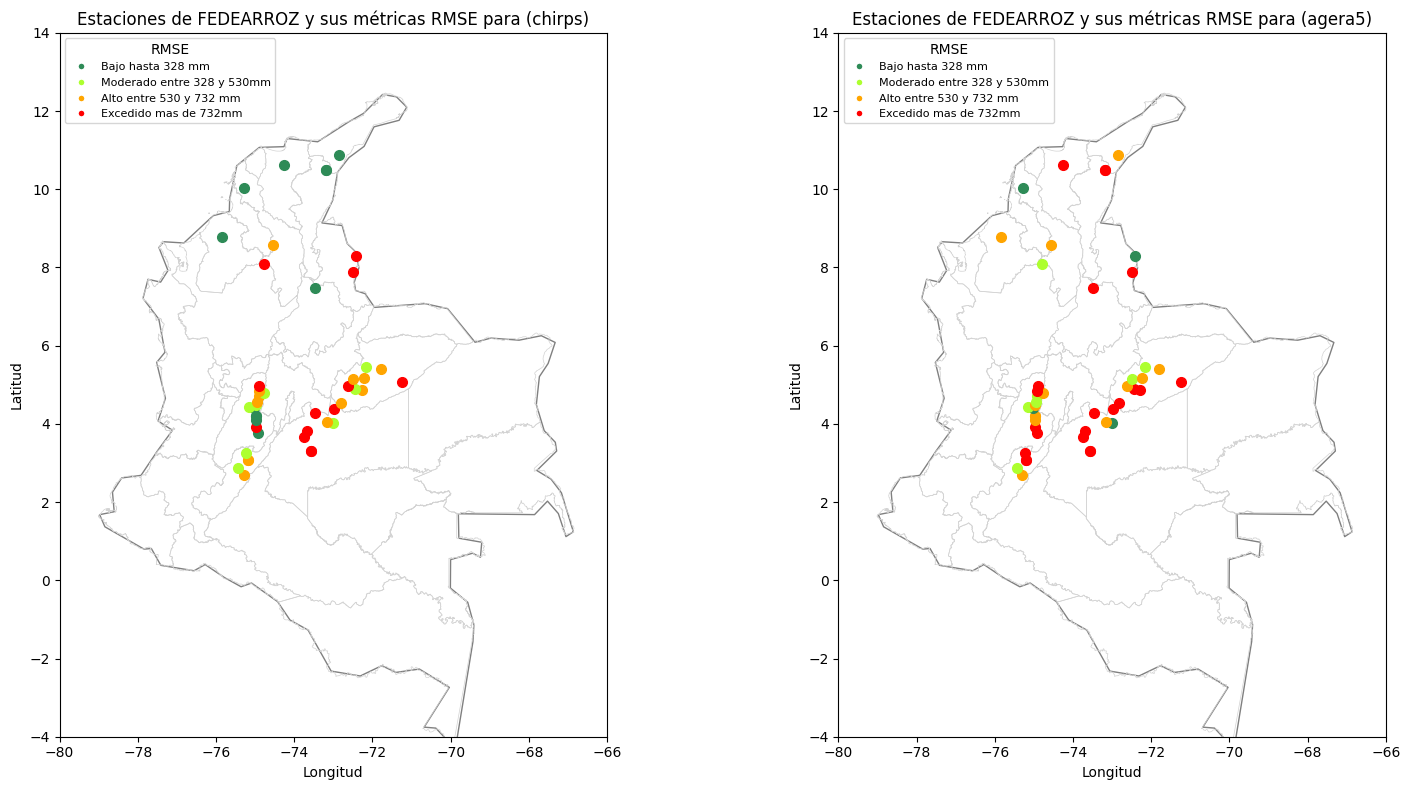

In [21]:
def plot_rmse(df, source, ax):
    df_source = df[df['source'] == source]
    
    #Colombia en blanco
    colombia.plot(ax=ax, edgecolor='gray', facecolor='white')
    #  departamentos en gris claro
    departments.plot(ax=ax, edgecolor='lightgray', facecolor='none', linewidth=0.5)

    # colores según el valor de MAPE
    def get_color(mrse):
        if limites_rmse["Bajo"][0] <= mrse < limites_rmse["Bajo"][1]:
            return '#2E8B57'  # Verde oscuro
        elif limites_rmse["Moderado"][0] <= mrse < limites_rmse["Moderado"][1]:
            return '#ADFF2F'  # Amarillo verdoso
        elif limites_rmse["Alto"][0] <= mrse < limites_rmse["Alto"][1]:
            return 'orange'
        else:
            return 'red'

    #pintar los ptos
    for _, row in df_source.iterrows():
        ax.plot(row['longitud'], row['latitud'], marker='o', markersize=7, color=get_color(row['rmse']), label=row['station'])

   
    ax.set_xlim([-80, -66])
    ax.set_ylim([-4, 14])
    ax.set_aspect('equal')
    
    # leyenda mape
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Bajo hasta 328 mm', markerfacecolor='#2E8B57', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Moderado entre 328 y 530mm', markerfacecolor='#ADFF2F', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Alto entre 530 y 732 mm', markerfacecolor='orange', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Excedido mas de 732mm', markerfacecolor='red', markersize=5)
    ]
    
    ax.legend(handles=legend_elements, title="RMSE", loc='upper left', fontsize=8)

    # Título y etiquetas
    ax.set_title(f'Estaciones de FEDEARROZ y sus métricas RMSE para ({source})', fontsize=12)
    ax.set_xlabel('Longitud', fontsize=10)
    ax.set_ylabel('Latitud', fontsize=10)

# Crear la figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plot_rmse(df_metricas_overall, 'chirps', ax=ax1)
plot_rmse(df_metricas_overall, 'agera5', ax=ax2)


plt.tight_layout()
plt.show()
